In [2]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F      # activation function
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline            # Create pipeline
from sklearn.model_selection import train_test_split  # split adata
from sklearn.preprocessing import StandardScaler      # Standardzation
from sklearn.preprocessing import KBinsDiscretizer    # Discretization

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core import display as ICD
import seaborn as sns
import glob
import scipy
import os
pd.set_option('display.max_columns', 100)
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

# Load the data

In [4]:
DATA_FOLDER = './avg_data/'
os.listdir(DATA_FOLDER)
all_anem=glob.glob(DATA_FOLDER + "anem*")
mast_anem=all_anem[:6]
top_anem=all_anem[6]
only_mag=True
h=np.arange(1.5,22,4)
df_list=[]
for idx,i in enumerate(mast_anem):
    df_temp=pd.read_csv(i, sep=" ", header=None, index_col=0, names=['u','direction'])
    df_temp['h']=h[idx]
    df_list.append(df_temp)
mast_anem_df = pd.concat(df_list)
rad_df = pd.read_csv(DATA_FOLDER+'radiometer.csv', sep=" ",index_col=0)
temp_df = pd.read_csv(DATA_FOLDER+'surf_temp.txt', sep=" ",index_col=0)
top_anem_df = pd.read_csv(top_anem, sep=" ",index_col=0,names=['u_top','direction_top'])
time_var_df = top_anem_df.merge(rad_df,how='left', left_index=True,right_index=True)
time_var_df = time_var_df.merge(temp_df,how='left', left_index=True,right_index=True)
tot_df=mast_anem_df.merge(time_var_df,how='left', left_index=True,right_index=True)
tot_df = tot_df.dropna(axis=0, how='any')
tot_df = tot_df.drop(columns=['Albedo [-]'])
tot_df.head()

,u,direction,h,u_top,direction_top,Pyranometer Upper Irradiance [W/m$^2$],Pyranometer Lower Irradiance [W/m$^2$],Pyrgeometer Upper Irradiance [W/m$^2$],Pyrgeometer Lower Irradiance [W/m$^2$],Net Solar radiation [W/m$^2$],Net (total) radiation [W/m$^2$],Net Far Infrared radiation [W/m$^2$],Sky temperature [°C],Radiometer Ground temperature [°C],Sensor Ground temperature [°C],North temperature [°C],East temperature [°C],South temperature [°C],West temperature [°C]
2018-11-14 00:00:00,0.66,160.0,1.5,2.76,298.0,1.8,-2.9,369.0,364.7,4.7,9.0,4.3,10.9,10.0,10.5,13.1,11.8,11.6,10.5
2018-11-14 00:00:00,0.91,225.0,5.5,2.76,298.0,1.8,-2.9,369.0,364.7,4.7,9.0,4.3,10.9,10.0,10.5,13.1,11.8,11.6,10.5
2018-11-14 00:00:00,0.57,185.0,9.5,2.76,298.0,1.8,-2.9,369.0,364.7,4.7,9.0,4.3,10.9,10.0,10.5,13.1,11.8,11.6,10.5
2018-11-14 00:00:00,2.64,284.0,13.5,2.76,298.0,1.8,-2.9,369.0,364.7,4.7,9.0,4.3,10.9,10.0,10.5,13.1,11.8,11.6,10.5
2018-11-14 00:00:00,2.98,313.0,17.5,2.76,298.0,1.8,-2.9,369.0,364.7,4.7,9.0,4.3,10.9,10.0,10.5,13.1,11.8,11.6,10.5


# Data preprocessing

In [5]:
X = np.array(tot_df.drop(columns=['u', 'direction']))
Y = np.array(tot_df[['u']]) # First consider 1 dimension output

# Make pipeline
#preprocessing = make_pipeline(StandardScaler(),KBinsDiscretizer(n_bins=20, encode='ordinal'),StandardScaler())
k = StandardScaler().fit(X)
X = k.transform(X)
k = KBinsDiscretizer(n_bins=20,encode='ordinal',strategy='uniform').fit(X)
X = k.transform(X) 
k = StandardScaler().fit(X)
X = k.transform(X)

k = StandardScaler().fit(Y)
Y = k.transform(Y)
k = KBinsDiscretizer(n_bins=20,encode='ordinal',strategy='uniform').fit(Y)
Y = k.transform(Y) 
k = StandardScaler().fit(Y)
Y = k.transform(Y)
# Split the data
x_tr_, x_te_, y_tr_, y_te_ = train_test_split(X, Y, test_size = 0.3, random_state = 0)

In [6]:
#k = preprocessing.fit(X)
#X = preprocessing.transform(X)  ## doesn't work
print X.shape

(8460, 17)


# Neural Network

### Build the Net

In [100]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden)  
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)  
        
    def forward(self, x):
        a1 = F.relu(self.hidden1(x)) 
        a2 = F.relu(self.hidden2(a1))
        #a1 = torch.sigmoid(self.hidden(x))
        #a1 = self.hidden(x) # 隐藏层用 relu
        y = self.predict(a2)
        return y

net = Net(n_feature=17, n_hidden=100, n_output=1)
print(net)

Net(
  (hidden1): Linear(in_features=17, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
)


In [101]:
loss_func = torch.nn.MSELoss()   
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)

### Prepare the data

#### Our data

In [102]:
x_tr = torch.from_numpy(x_tr_[:,:])
y_tr = torch.from_numpy(y_tr_)
x_te = torch.from_numpy(x_te_[:,:])
y_te = torch.from_numpy(y_te_)
x_tr = x_tr.type(torch.FloatTensor)
y_tr = y_tr.type(torch.FloatTensor)
x_te = x_te.type(torch.FloatTensor)
y_te = y_te.type(torch.FloatTensor)
x_tr, y_tr = Variable(x_tr), Variable(y_tr)
x_te, y_te = Variable(x_te), Variable(y_te)
print x_te.size()
print y_tr.size()
#y_train = y_train.view(8459, 1) 
#x_tr = x_tr.view(5922, 1)
#x_te = x_te.view(2538, 1)
print x_tr.size()
print x_te.size()

torch.Size([2538, 17])
torch.Size([5922, 1])
torch.Size([5922, 17])
torch.Size([2538, 17])


#### The data for testing the net

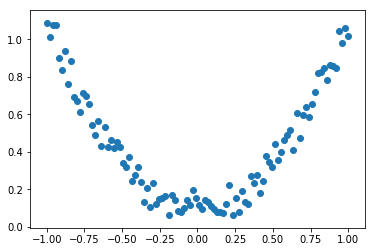

In [83]:
x_tr = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y_tr = x_tr.pow(2) + 0.2*torch.rand(x_tr.size())                 # noisy y data (tensor), shape=(100, 1)

# 画图
plt.scatter(x_tr.data.numpy(), y_tr.data.numpy())
plt.show()

### Train the Net

In [103]:
import matplotlib.pyplot as plt

#plt.ion()   # 画图
#plt.show()

for t in range(200):
    prediction = net(x_tr)
    loss = loss_func(prediction, y_tr)
    #print loss
    optimizer.zero_grad()    # clear gradients for next train
    loss.backward()          # backpropagation
    optimizer.step()         # update（w、b）
    #if t % 5 == 0:
        # plot and show learning process
        #plt.cla()
        #plt.scatter(x_tr.data.numpy(), y_tr.data.numpy())
        #plt.plot(x_tr.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
       # plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        #plt.pause(0.1)

### Predict

In [104]:
print loss
net.eval()
predict = net(x_tr)
predict = predict.data.numpy()

tensor(0.1145, grad_fn=<MseLossBackward>)


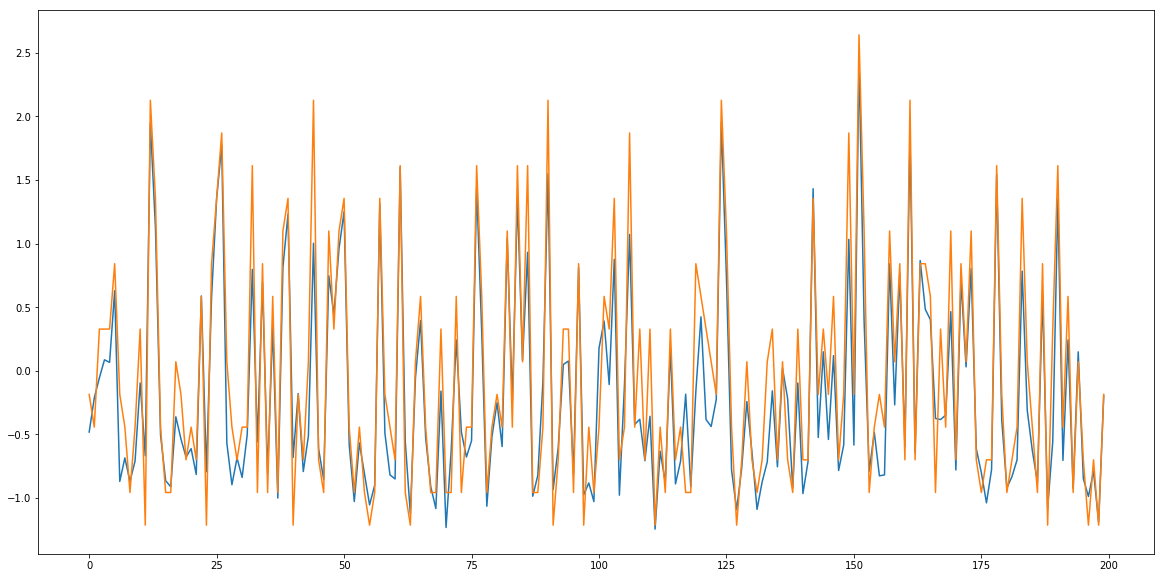

In [108]:
plt.figure(figsize=(20,10))
plt.plot(predict[0:200])
plt.plot(np.array(y_tr)[0:200])

In [110]:
print np.mean(np.square(np.array(y_tr)-predict))

0.11675976
